# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import ast
import re
from timeit import default_timer as timer
import random
import numpy as np

C:\Users\dom\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [2]:
#Function that writes to csv
def save_data(x):
    x.to_csv('dataintermediate.csv', index=False)

# Data preparation

### Read Data and select columns for Model

In [3]:
df = pd.read_csv('datav.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374687 entries, 0 to 374686
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335392 non-null  object
 1   private pool  4197 non-null    object
 2   propertyType  340127 non-null  object
 3   street        374686 non-null  object
 4   baths         269465 non-null  object
 5   homeFacts     374687 non-null  object
 6   fireplace     102486 non-null  object
 7   city          374657 non-null  object
 8   schools       374687 non-null  object
 9   sqft          334483 non-null  object
 10  zipcode       374687 non-null  object
 11  beds          283832 non-null  object
 12  state         374686 non-null  object
 13  stories       224861 non-null  object
 14  mls-id        25078 non-null   object
 15  PrivatePool   40296 non-null   object
 16  MlsId         310313 non-null  object
 17  target        374687 non-null  int64 
dtypes: int64(1), object(17)


#### If to drop all NAs from data frame then there will be an empty table. So some work is required per each column separately

In [4]:
#First I will use most commonsence properties that might influence the property Price
data = df[['status', 'private pool', 'baths',
           'homeFacts', 'fireplace', 'schools',
           'sqft', 'beds', 'state', 'stories',
           'PrivatePool', 'propertyType', 'target']]

### Property type

In [5]:
data.propertyType = data.propertyType.fillna('0')
data.propertyType = data.propertyType.str.lower()

In [6]:
data.propertyType[data.propertyType.str.contains('single')] = '1'
data.propertyType[data.propertyType.str.contains('condo')] = '2'
data.propertyType[data.propertyType.str.contains('land')] = '3'
data.propertyType[data.propertyType.str.contains('townhouse')] = '4'
data.propertyType[data.propertyType.str.contains('multi')] = '5'
data.propertyType[data.propertyType.str.contains('traditional')] = '6'
data.propertyType[data.propertyType.str.contains('coop')] = '7'
data.propertyType[data.propertyType.str.contains('\D')] = '8'

In [7]:
data.propertyType[data.propertyType.str.contains('\D')].value_counts(normalize=True)

Series([], Name: propertyType, dtype: float64)

In [8]:
data.propertyType.value_counts(normalize=True)

1    0.503316
2    0.136762
0    0.092237
3    0.084316
8    0.071006
4    0.048763
5    0.033276
6    0.019977
7    0.010347
Name: propertyType, dtype: float64

In [9]:
data.propertyType = data.propertyType.astype(int)

### Price of the Property (target) 

In [10]:
data.target.fillna(0, inplace=True)

In [13]:
data.target

0          339900
1          223000
2         3195000
3          715000
4         1224500
           ...   
374682     144900
374683     199000
374684      28900
374685     575000
374686      55000
Name: target, Length: 374687, dtype: int64

In [11]:
#find symbols that are not numbers to replace
symbollist = data.target.str.findall(r'\D').value_counts().reset_index()['index']
s = list()
for i in symbollist:
    s = s + i
s = list(set(s))
s = ''.join(s)
print(f'Next symbols are to be replaced {s}')

AttributeError: Can only use .str accessor with string values!

In [16]:
#Function that First remove ",","+","/mo" from all string values then If the string value is a range - take the average
#Function returns for strings it's numeric value
def clean_currency(x):
    """replace redundent symbols"""
    if isinstance(x, str):
        x = x.replace('$', '').replace(',', '').replace('+', '').replace('/mo', '')
      
    #for values that appears as range take the average
    if isinstance(x, str) and x.find(' - ') > 0:
        a = x.find(' - ')
        return((float(x[:a]) + float(x[a + 3:]))/2)  
    return(float(x))

In [17]:
data['target'] = data['target'].apply(clean_currency)
data = data.rename(columns={'target':'Price'})

In [18]:
data.Price = data.Price.astype(float)

In [19]:
print(f'There is {round(data.Price[data.Price == 0].count() / len(data.Price) * 100, 2)}% of missing values in Price')

There is 0.0% of missing values in Price


## Before dropping I will try to reduce the amount on NAs by other columns

## HomeFacts

In [20]:
data['homeFacts'] = data['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'])

In [21]:
#Get Labels for df columns

def getdata(x):
    labels = list()
    for i in x:
        labels.append(i['factLabel'])
    return labels

labels = getdata(data.homeFacts[1])
labels

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [22]:
#Convert dictionaries per row to appropriate columns in df and extract all the values
for l in labels:
    data[l] = data['homeFacts'].apply(lambda x: x[labels.index(l)]['factValue']) 

In [23]:
save_data(data)

### Lotsize

In [24]:
data = pd.read_csv('dataintermediate.csv')

In [25]:
data.lotsize.iloc[10]

'0.52 acres'

In [26]:
# change strings to lower case and fill NAs and blanks with 0
data.lotsize = data.lotsize.str.lower().str.strip()
data.lotsize.fillna('0',inplace = True)

In [27]:
#create 2 lists of indexes , for values that contains "acre" and "sq" substrings
sq_index = data.lotsize[data.lotsize.str.contains('sq') == True].index
acre_index = data.lotsize[data.lotsize.str.contains('acre') == True].index

In [28]:
#Remove all literals from values that contain "sq"
data.lotsize.iloc[sq_index]=data.lotsize.iloc[sq_index].str.replace(r'\D','')

In [29]:
#Remove all literals from values that contain "acre" convert to float and convert to sqft
data.lotsize.iloc[acre_index] = round(data.lotsize.iloc[acre_index].str.replace('[a-z, ]','').astype(float) * 43560.04, 0)

In [30]:
#Take care of other literals too and blank values
other_index=data.lotsize[data.lotsize.str.contains('—|[a-z]') == True].index
data.lotsize.iloc[other_index] = '0'
other_index=data.lotsize[data.lotsize.str.contains(',') == True].index
data.lotsize.iloc[other_index] = data.lotsize.iloc[other_index].str.replace(',','')
data.lotsize[data.lotsize == ''] = 0

In [31]:
data.lotsize=data.lotsize.astype(float)

In [32]:
save_data(data)

## Price/sqft

In [33]:
data = pd.read_csv('dataintermediate.csv')

In [34]:
data['Price/sqft'] = data['Price/sqft'].str.lower()

In [35]:
#Get rid of strings near numbers
blank_list = ['$', '/sqft', ' / sq. ft.', ',']
for v in blank_list:
    data['Price/sqft'] = data['Price/sqft'].str.replace(v,'')

In [36]:
#Replace strings that mean no value to 0
zero_list = ['no data', 'no info', 'contact manager']
for v in zero_list:
    data['Price/sqft'] = data['Price/sqft'].str.replace(v,'0')    

In [37]:
data['Price/sqft'].fillna(0,inplace=True)

In [38]:
data['Price/sqft'] = data['Price/sqft'].astype(int)

## sqft

In [39]:
data.sqft=data.sqft.str.replace('\D','')

Before dropping Na's from sqft column I will retrieve information from Price/sqft, Price, lotsize, beds, baths

In [40]:
data.sqft = data.sqft.fillna(0)
data.sqft[data.sqft == ''] = 0
data.sqft = data.sqft.astype(float)
data.sqft[data.sqft < 0] = 0

In [41]:
print(f'There is {round((data.sqft[data.sqft == 0].count()) / len(data.sqft) * 100, 2)}% of missing values in sqft')

There is 14.12% of missing values in sqft


In [42]:
#use values from beds that points on area measurement data for filling 0 for sqft
values = data['beds'][(data.beds.str.contains('sqft') == True) & (data.sqft == 0)].str.replace('\D', '')
values.drop(labels = values[values == ''].index, inplace = True)
values=values.astype(float)
valuesA = data['beds'][(data.beds.str.contains('acres') == True) & (data.sqft == 0)]
valuesA = round(valuesA.str.replace('[a-z]', '').astype(float) * 43560.04, 2) 
data['sqft'].iloc[values.index] = values
data['sqft'].iloc[valuesA.index] = valuesA

In [43]:
data['beds'][data.beds.str.contains('sqft|arcres') == True] = 0

In [44]:
print(f'There is {round((data.sqft[data.sqft == 0].count()) / len(data.sqft) * 100, 2)}% of missing values in sqft')

There is 13.38% of missing values in sqft


In [45]:
#Fill NAs of sqft with values from lotsize
data.sqft[data.sqft == 0] = data.lotsize[data.sqft == 0]

In [46]:
print(f'There is {round((data.sqft[data.sqft == 0].count()) / len(data.sqft) * 100, 2)}% of missing values in sqft')

There is 3.24% of missing values in sqft


In [47]:
data1=data[['Price/sqft','sqft','Price']][(data.sqft == 0) & (data.Price != 0) & (data['Price/sqft'] != 0)]
print(f'There is {len(data1)} values Price/sqft and Price that can be used for sqft missing values')

There is 378 values Price/sqft and Price that can be used for sqft missing values


In [48]:
#replace missing values of sqft with [Price]/[Price/sqft]
data1.sqft = data1.Price / data1['Price/sqft']

In [49]:
data.sqft.iloc[data1.index] = data1.sqft

In [50]:
print(f'There is {round((data.sqft[data.sqft == 0].count()) / len(data.sqft) * 100, 2)}% of missing values in sqft')

There is 3.14% of missing values in sqft


Before taking the mean for missing values, I'll drop the exceptences

In [51]:
data.sqft.describe()

count    3.746870e+05
mean     3.794977e+04
std      4.601768e+06
min      0.000000e+00
25%      1.300000e+03
50%      1.943000e+03
75%      3.049000e+03
max      1.859533e+09
Name: sqft, dtype: float64

In [52]:
#sqft distribution
data.sqft.value_counts(normalize=True, bins=10)

(-1859532.841, 185953284.0]     0.999981
(1673579556.0, 1859532840.0]    0.000005
(371906568.0, 557859852.0]      0.000005
(185953284.0, 371906568.0]      0.000005
(557859852.0, 743813136.0]      0.000003
(1487626272.0, 1673579556.0]    0.000000
(1301672988.0, 1487626272.0]    0.000000
(1115719704.0, 1301672988.0]    0.000000
(929766420.0, 1115719704.0]     0.000000
(743813136.0, 929766420.0]      0.000000
Name: sqft, dtype: float64

In [53]:
data.drop(data.sqft[data.sqft > 214748364.7].index, inplace = True)

In [54]:
#Group data according to property type and take the average area for each property type for NA
area = data[['sqft','propertyType']][data.sqft != 0].groupby(by='propertyType').mean().reset_index()
area
area.sqft = area.sqft.round(decimals=0)
data.sqft[data.sqft == 0] = data[data.sqft == 0].merge(area, on='propertyType', how='left').sqft_y

In [55]:
data.sqft.fillna(0, inplace = True)

### Use sqft and Price/sqft to fill Price na's

In [56]:
#replace Price missing values with [sqft]*[Price/sqft]
data2 = data[['Price/sqft','sqft','Price']][(data.Price == 0) & (data.sqft != 0) & (data['Price/sqft'] != 0)]
data2.Price = data2.sqft * data2['Price/sqft']
data['Price'].iloc[data2.index] = data2.Price
print(f'There is {round(data.Price.isna().sum() / len(data.Price) * 100, 2)}% of missing values in Price')

There is 0.0% of missing values in Price


In [57]:
data.drop(['Price/sqft','lotsize'], axis=1, inplace=True)

### Replace the rest missing values in Price and sqft to mean and normalizing

In [58]:
data.Price[data.Price == 0] = data.Price[data.Price != 0].mean()
data.Price.fillna(data.Price[data.Price.isna() == False].mean(), inplace=True)
data.sqft[data.sqft == 0] = data.sqft[data.sqft != 0].mean()

In [59]:
#price distribution
data.Price.value_counts(normalize=True, bins=10)

(-164999.0, 16500000.9]       0.998132
(16500000.9, 33000000.8]      0.001433
(33000000.8, 49500000.7]      0.000267
(49500000.7, 66000000.6]      0.000112
(66000000.6, 82500000.5]      0.000027
(82500000.5, 99000000.4]      0.000013
(148500000.1, 165000000.0]    0.000005
(115500000.3, 132000000.2]    0.000005
(99000000.4, 115500000.3]     0.000005
(132000000.2, 148500000.1]    0.000000
Name: Price, dtype: float64

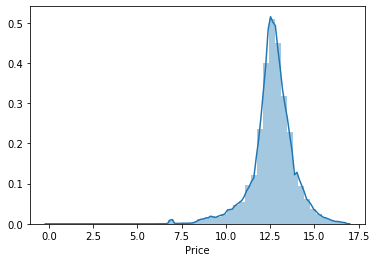

In [60]:
sns.distplot(np.log(data.Price[(data.Price > 0) & (data.Price <= 19500000.9)]))

In [61]:
#get rid of exceptions data
data.drop(data.Price[(data.Price <= 0) | (data.Price > 19500000.9)].index, axis=0 , inplace=True)

In [62]:
#normalizing Price
data.Price = np.log(data.Price)

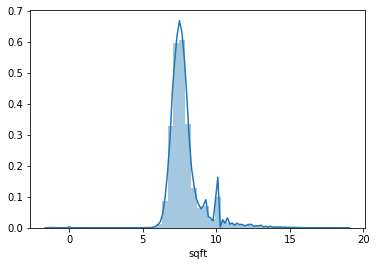

In [63]:
sns.distplot(np.log(data.sqft))

In [64]:
#normalizing sqft
data.sqft = np.log(data.sqft)

In [65]:
#data.to_csv('dataintermediate.csv',index=False)
save_data(data)

In [66]:
data = pd.read_csv('dataintermediate.csv')

## Schools

In [67]:
data = pd.read_csv('dataintermediate.csv')
data['schools'] = data['schools'].apply(lambda x: ast.literal_eval(x)[0])

In [68]:
#Extract rating list to school_rating column
data['school_rating'] = data['schools'].apply(lambda x: [n for n in x['rating'] if n != 'NR']) 

In [69]:
def find_rating(x):
    '''Function that makes an order in ratings and takes the maximum'''
    l = [0]
    for i in x:
        if (i.find('/') > -1 and i[:i.find('/')] == 'None') or i == 'NA' or i == '':
            l.append(0)
        elif i.find('/') > -1:
            l.append(int(i[:i.find('/')]))
        else:
            l.append(int(i))
    return max(l)

In [70]:
data['school_rating'] = data['school_rating'].apply(lambda x: find_rating(x))

In [71]:
save_data(data)

## Year built and remodeled

In [72]:
data = pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374179 entries, 0 to 374178
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          334914 non-null  object 
 1   private pool    4192 non-null    object 
 2   baths           269106 non-null  object 
 3   homeFacts       374179 non-null  object 
 4   fireplace       102310 non-null  object 
 5   schools         374179 non-null  object 
 6   sqft            374179 non-null  float64
 7   beds            283454 non-null  object 
 8   state           374178 non-null  object 
 9   stories         224633 non-null  object 
 10  PrivatePool     40102 non-null   object 
 11  propertyType    374179 non-null  int64  
 12  Price           374179 non-null  float64
 13  Year built      312136 non-null  object 
 14  Remodeled year  149786 non-null  float64
 15  Heating         265880 non-null  object 
 16  Cooling         251443 non-null  object 
 17  Parking   

In [73]:
#put indexes of str and num values in to variables
stri = data['Year built'][data['Year built'].str.contains('\D') == True].index
numi = data['Year built'][data['Year built'].str.contains('\D') == False].index

In [74]:
#replace exeptions where there is no sence (smaller than 0 or bigger than 2020) by No Data
iyearexp = data['Year built'].iloc[numi].astype('int64')
iyearexp = iyearexp[(data['Year built'].iloc[numi].astype('int64') < 0)
                    | (data['Year built'].iloc[numi].astype('int64') > 2020)].index
data['Year built'].iloc[iyearexp] = 'No Data'
numi=data['Year built'][data['Year built'].str.contains('\D') == False].index
stri=data['Year built'][data['Year built'].str.contains('\D') == True].index

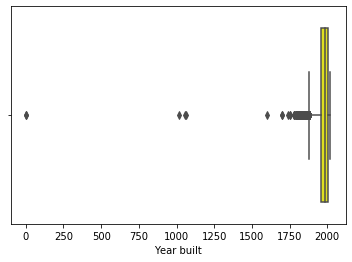

In [75]:
#Check if there are more exeptions
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color = 'yellow');

In [76]:
#Drop more exeptions values that smaller than 1500 -> update number indexes value
iyearexp=data['Year built'].iloc[numi].astype('int64')
iyearexp = iyearexp[(data['Year built'].iloc[numi].astype('int64') < 1500)
                    | (data['Year built'].iloc[numi].astype('int64') > 2020)].index
data['Year built'].iloc[iyearexp] = 'No Data'
numi=data['Year built'][data['Year built'].str.contains('\D') == False].index
stri=data['Year built'][data['Year built'].str.contains('\D') == True].index

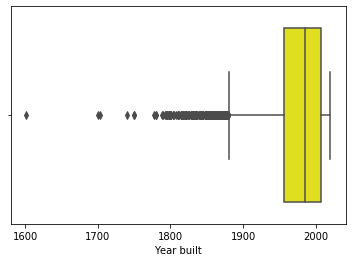

In [77]:
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [78]:
#convert numeric data to integer
data['Year built'].iloc[numi] = data['Year built'].iloc[numi].astype(int)

In [79]:
data['Year built'].iloc[numi].value_counts(normalize=True, bins=10)

(1978.1, 2020.0]     0.563178
(1936.2, 1978.1]     0.305595
(1894.3, 1936.2]     0.122950
(1852.4, 1894.3]     0.007450
(1810.5, 1852.4]     0.000650
(1768.6, 1810.5]     0.000158
(1726.7, 1768.6]     0.000010
(1684.8, 1726.7]     0.000006
(1600.58, 1642.9]    0.000003
(1642.9, 1684.8]     0.000000
Name: Year built, dtype: float64

In [80]:
#replace string data to mean of numeric data
data['Year built'].iloc[stri] = int(round(data['Year built'].iloc[numi].mean(),0))

In [81]:
#fill nas with the mean of numeric values
data['Year built'].fillna(int(round(data['Year built'].iloc[numi].mean(),0)), inplace=True)

In [82]:
data['Year built'].describe()

count    374179.000000
mean       1979.200401
std          30.631504
min        1601.000000
25%        1963.000000
50%        1979.000000
75%        2005.000000
max        2020.000000
Name: Year built, dtype: float64

In [83]:
data['Remodeled year'].fillna(data['Remodeled year'].notnull().mean(), inplace=True)
data['Remodeled year'] = data['Remodeled year'].astype(int)

### Status

In [84]:
data.status.value_counts(normalize=True)

for sale                   0.466281
Active                     0.313427
For sale                   0.129789
foreclosure                0.016927
New construction           0.016019
                             ...   
Coming soon: Nov 8.        0.000003
Pending W/Escape Clause    0.000003
Coming soon: Dec 27.       0.000003
Coming soon: Dec 12.       0.000003
Accepting backups          0.000003
Name: status, Length: 158, dtype: float64

In [85]:
data.status[data.status.str.contains('for sale|active|accepted') == True] = 1

In [86]:
data.status[data.status != 1] = 0

In [87]:
data.status = data.status.astype(int)

### Private Pool

In [88]:
data['PrivatePool'] = data['PrivatePool'].str.lower()
data['private pool'] = data['private pool'].str.lower()

In [89]:
# Replace 'yes' with 1 and unufy "private pool" and PrivatePool and replace NA with 0
data[['private pool','PrivatePool']] = data[['private pool','PrivatePool']].replace(to_replace=['yes'],value = 1)
data['PrivatePool'] = data['PrivatePool'].fillna(data['private pool'])
data['PrivatePool'] = data['PrivatePool'].fillna(0)
data = data.drop(['private pool'], axis=1)

In [90]:
data.PrivatePool = data.PrivatePool.astype(int)
data.PrivatePool.value_counts()

0    329885
1     44294
Name: PrivatePool, dtype: int64

In [91]:
data.head()

,status,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,school_rating
0,0,"2,000","[{'factValue': '2009', 'factLabel': 'Year buil...",NaN,"{'rating': ['8', '6', '4'], 'data': {'Distance...",7.436028,Baths,FL,NaN,0,8,12.736407,2009,2010,Central Air,Has Cooling,NaN,8
1,1,2 Baths,"[{'factValue': '1991', 'factLabel': 'Year buil...",NaN,"{'rating': ['8/10', '5/10', '4/10', '3/10', '5...",7.083388,3 Beds,FL,1.0,1,1,12.314927,1991,1991,Forced Air,Central,"Carport, Attached Garage",8
2,1,NaN,"[{'factValue': '', 'factLabel': 'Year built'},...",NaN,"{'rating': ['9/10', '9/10', '9/10'], 'data': {...",10.996702,NaN,CA,NaN,0,3,14.977098,1979,0,NaN,NaN,NaN,9
3,0,NaN,"[{'factValue': '2006', 'factLabel': 'Year buil...",NaN,"{'rating': ['9', '10', 'NR', '6', '5'], 'data'...",9.017362,NaN,FL,NaN,0,8,13.480038,2006,2006,NaN,NaN,NaN,10
4,1,4 Baths,"[{'factValue': '2003', 'factLabel': 'Year buil...",yes,"{'rating': ['6/10', '5/10', '3/10'], 'data': {...",8.419580,3 Beds,TX,3.0,1,1,14.018043,2003,2003,Other,Central,Attached Garage,6


### Bath

In [92]:
data.baths = data.baths.str.lower()
print(f'There are {round(data.baths.isna().sum() / data.baths.count() * 100, 0)}% missing values')

There are 39.0% missing values


In [93]:
#Leave cells with numbers only for Bath 
data['baths'] = data.baths.str.findall(r'\d').str[0]

In [94]:
data['baths'][data.baths.isna() == False] = data['baths'][data.baths.isna() == False].astype(int)

In [95]:
data.baths.value_counts(normalize=True)

2.0    0.444974
3.0    0.271228
4.0    0.104047
1.0    0.095961
5.0    0.037180
6.0    0.016546
0.0    0.014715
7.0    0.008949
8.0    0.004439
9.0    0.001962
Name: baths, dtype: float64

In [96]:
#Group data according to property type and take the average bathrooms for each property type for NA
Baths = data[['baths','propertyType']]
Baths['baths'] = Baths['baths'][Baths.baths.isna() == False].astype(int)
Baths = Baths[Baths.baths.isna() == False].groupby(by='propertyType').mean().reset_index()
Baths.baths = Baths.baths.round(decimals=0)
data.baths[data.baths.isna() == True] = data[data.baths.isna() == True].merge(Baths, on='propertyType', how='left').baths_y

In [97]:
#Group data according to bedrooms and take the average bathrooms for each bedroom number for NA
BathsBeds = data[['baths','beds']]
BathsBeds['baths'] = BathsBeds['baths'][BathsBeds.baths.isna() == False].astype(int)
BathsBeds = BathsBeds[BathsBeds.baths.isna() == False].groupby(by='beds').mean().reset_index()
BathsBeds.baths = BathsBeds.baths.round(decimals = 0)
data.baths[data.baths.isna() == True] = data[data.baths.isna() == True].merge(BathsBeds, on='beds', how='left').baths_y
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374179 entries, 0 to 374178
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          374179 non-null  int32  
 1   baths           297802 non-null  object 
 2   homeFacts       374179 non-null  object 
 3   fireplace       102310 non-null  object 
 4   schools         374179 non-null  object 
 5   sqft            374179 non-null  float64
 6   beds            283454 non-null  object 
 7   state           374178 non-null  object 
 8   stories         224633 non-null  object 
 9   PrivatePool     374179 non-null  int32  
 10  propertyType    374179 non-null  int64  
 11  Price           374179 non-null  float64
 12  Year built      374179 non-null  int64  
 13  Remodeled year  374179 non-null  int32  
 14  Heating         265880 non-null  object 
 15  Cooling         251443 non-null  object 
 16  Parking         200308 non-null  object 
 17  school_rat

In [98]:
#check if some values can be taken from beds column
data['beds'][(data.beds.str.contains('Bath')) & (data.beds.isna() == False)&(data.baths.isna() == True)]

106802     Bath
108409     Bath
108490    Baths
108544     Bath
109022    Baths
          ...  
372129    Baths
373130     Bath
373605    Baths
373707     Bath
373746    Baths
Name: beds, Length: 1085, dtype: object

In [99]:
#beds columns has values that contains baths, replace NA with 1 for bath and 2 for baths
data['beds'][(data.beds == 'Bath') & (data.beds.isna() == False) & (data.baths.isna() == True)] = 1
data['beds'][(data.beds == 'Baths') & (data.beds.isna() == False) & (data.baths.isna() == True)] = 2
data['baths'][(data.beds.str.contains('Bath')) & (data.beds.isna() == False) & (data.baths.isna() == True)] = 1

In [100]:
#Group data according to sqft and take the average bathrooms for each area for NA
BathsArea = data[['baths','sqft']]
BathsArea['baths'] = BathsArea['baths'][BathsArea.baths.isna() == False].astype(int)
BathsArea = BathsArea[BathsArea.baths.isna() == False].groupby(by ='sqft').mean().reset_index()
BathsArea.baths = BathsArea.baths.round(decimals=0)
data.baths[data.baths.isna() == True] = data[data.baths.isna() == True].merge(BathsArea, on='sqft', how='left').baths_y

In [101]:
data.baths.fillna(1, inplace=True)
data.baths = data.baths.astype(int)

### Beds

In [102]:
data.beds = data.beds.str.lower()
print(f'There are {round(data.beds.isna().sum()/data.baths.count()*100,0)}% of missing values')

There are 25.0% of missing values


In [103]:
data.beds.value_counts(normalize=True)

3 beds         0.188218
4 beds         0.124810
3              0.109599
2 beds         0.092725
4              0.070725
                 ...   
39.47 acres    0.000004
9.06 acres     0.000004
48 beds        0.000004
18.23 acres    0.000004
7.34 acres     0.000004
Name: beds, Length: 562, dtype: float64

In [104]:
#leave numbers only for Beds
data['beds'] = data.beds.str.replace(' beds', '').str.replace(' bd', '')
data['beds'] = data.beds.str.replace('baths', '2')
data['beds'] = data.beds.str.replace('bath', '1')
data.beds[(data.beds.str.contains('\D') == True) & (data.beds.isna() == False)].value_counts(normalize=True)

3.0            0.388997
4.0            0.245678
2.0            0.114408
5.0            0.065254
--             0.038962
                 ...   
6.06 acres     0.000048
18.23 acres    0.000048
4.59 acres     0.000048
6.62 acres     0.000048
58.9 acres     0.000048
Name: beds, Length: 451, dtype: float64

In [105]:
data['beds'][data.beds.str.contains('sqft|acres|acre| |--') == True] = 0


In [106]:
data['beds'][data.beds.str.contains('2 bedrooms') == True] = 2
data['beds'][data.beds.str.contains('3 or more bedrooms') == True] = 3
data['beds'][data.beds.str.contains('based on redfin|-') == True] = 1

In [107]:
data['beds'] = data['beds'][(data.beds.isna() == False) & (data.beds != 'none')].astype(float)

In [108]:
#Group data according to property type and take the average area for each property type for NA
Beds = data[['beds', 'propertyType']]
Beds['beds'] = Beds['beds'][(Beds.beds.isna() == False)&(Beds.beds != 'none')].astype(float)
Beds=Beds.groupby(by='propertyType').mean().reset_index()
Beds.beds = Beds.beds.round(decimals=0)
data = data.merge(Beds, on='propertyType', how='left')

In [109]:
data['beds_x'].fillna(data.beds_y, inplace=True)
data['beds_x'][data.beds_x == 'none'] = data.beds_y
data.beds_x.fillna(data.beds_x.mean(), inplace=True)
data.drop('beds_y', axis = 1, inplace=True)
data = data.rename(columns = {'beds_x':'beds'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374179 entries, 0 to 374178
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          374179 non-null  int32  
 1   baths           374179 non-null  int32  
 2   homeFacts       374179 non-null  object 
 3   fireplace       102310 non-null  object 
 4   schools         374179 non-null  object 
 5   sqft            374179 non-null  float64
 6   beds            374179 non-null  float64
 7   state           374178 non-null  object 
 8   stories         224633 non-null  object 
 9   PrivatePool     374179 non-null  int32  
 10  propertyType    374179 non-null  int64  
 11  Price           374179 non-null  float64
 12  Year built      374179 non-null  int64  
 13  Remodeled year  374179 non-null  int32  
 14  Heating         265880 non-null  object 
 15  Cooling         251443 non-null  object 
 16  Parking         200308 non-null  object 
 17  school_rat

In [110]:
data.beds.value_counts(normalize=True, bins=10)

(-0.145, 14.4]    0.999142
(14.4, 28.8]      0.000612
(57.6, 72.0]      0.000123
(28.8, 43.2]      0.000086
(43.2, 57.6]      0.000019
(72.0, 86.4]      0.000008
(129.6, 144.0]    0.000005
(86.4, 100.8]     0.000005
(115.2, 129.6]    0.000000
(100.8, 115.2]    0.000000
Name: beds, dtype: float64

In [111]:
data = data.drop(data.beds[data.beds > 15].index)

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373900 entries, 0 to 374178
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          373900 non-null  int32  
 1   baths           373900 non-null  int32  
 2   homeFacts       373900 non-null  object 
 3   fireplace       102290 non-null  object 
 4   schools         373900 non-null  object 
 5   sqft            373900 non-null  float64
 6   beds            373900 non-null  float64
 7   state           373899 non-null  object 
 8   stories         224520 non-null  object 
 9   PrivatePool     373900 non-null  int32  
 10  propertyType    373900 non-null  int64  
 11  Price           373900 non-null  float64
 12  Year built      373900 non-null  int64  
 13  Remodeled year  373900 non-null  int32  
 14  Heating         265731 non-null  object 
 15  Cooling         251320 non-null  object 
 16  Parking         200168 non-null  object 
 17  school_rat

### Create feature baths per bedroom

In [113]:
data['baths'][data['baths'] < 1] = 1
data['beds'][data['beds'] < 1] = 1
data['baths/bed'] = data['beds'] / data['baths']

In [114]:
save_data(data)

### Fireplace

In [115]:
data = pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373900 entries, 0 to 373899
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          373900 non-null  int64  
 1   baths           373900 non-null  int64  
 2   homeFacts       373900 non-null  object 
 3   fireplace       102290 non-null  object 
 4   schools         373900 non-null  object 
 5   sqft            373900 non-null  float64
 6   beds            373900 non-null  float64
 7   state           373899 non-null  object 
 8   stories         224520 non-null  object 
 9   PrivatePool     373900 non-null  int64  
 10  propertyType    373900 non-null  int64  
 11  Price           373900 non-null  float64
 12  Year built      373900 non-null  int64  
 13  Remodeled year  373900 non-null  int64  
 14  Heating         265731 non-null  object 
 15  Cooling         251320 non-null  object 
 16  Parking         200168 non-null  object 
 17  school_rat

In [116]:
data['fireplace'] = data['fireplace'].str.lower()
data.fireplace[data.fireplace.str.contains('fire|yes|gas|burning|stove|frplc') == True] = 1
data.fireplace[data.fireplace.str.contains('no|0 ') == True] = 0
data.fireplace[(data.fireplace.str.contains('\d') == True) & (data.fireplace.str.contains('0') == False)] = 1
data.fireplace[data.fireplace != 1] = 0

In [117]:
data.fireplace = data.fireplace.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373900 entries, 0 to 373899
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          373900 non-null  int64  
 1   baths           373900 non-null  int64  
 2   homeFacts       373900 non-null  object 
 3   fireplace       373900 non-null  int32  
 4   schools         373900 non-null  object 
 5   sqft            373900 non-null  float64
 6   beds            373900 non-null  float64
 7   state           373899 non-null  object 
 8   stories         224520 non-null  object 
 9   PrivatePool     373900 non-null  int64  
 10  propertyType    373900 non-null  int64  
 11  Price           373900 non-null  float64
 12  Year built      373900 non-null  int64  
 13  Remodeled year  373900 non-null  int64  
 14  Heating         265731 non-null  object 
 15  Cooling         251320 non-null  object 
 16  Parking         200168 non-null  object 
 17  school_rat

### Stories

In [118]:
data.stories = data.stories.str.lower()

In [119]:
data['st1'] = data.stories.str.findall(r'\d').str[0]
data.stories[(data.st1.isna() == True)&(data.stories.isna() == False)].value_counts()

one                        5816
two                        2431
three or more               562
one story                   404
lot                         354
                           ... 
other, two, multi/split       1
bedroom - split plan          1
double wide                   1
tri/multi level               1
stories                       1
Name: stories, Length: 87, dtype: int64

In [120]:
data.stories[data.stories.str.contains('one') == True] = 1
data.stories[data.stories.str.contains('two') == True] = 2

In [121]:
data.stories = data['st1'][(data.st1.isna() == False) & (data.stories.isna() == False)] 

In [122]:
data.drop('st1', axis=1, inplace=True)
data.dropna(subset=['stories'], axis=0, inplace=True)

In [123]:
data.stories = data.stories.astype(int)

In [124]:
data['stories'][data.stories < 2] = 1
data['stories'][data.stories > 1] = 2

In [125]:
data.stories.value_counts()

1    106518
2    105919
Name: stories, dtype: int64

In [126]:
save_data(data)

### Parking

In [127]:
data = pd.read_csv('dataintermediate.csv')
data.Parking.value_counts()

Attached Garage                                                  55565
2 spaces                                                         24192
1 space                                                          11285
No Data                                                           9492
Detached Garage                                                   8909
                                                                 ...  
2 Car, Assigned, DRVWY, Parking Lot                                  1
Assigned, DRVWY, On Street                                           1
Parking Space Conveys, Off Site                                      1
Boat, Driveway, Guest, Oversized, Parking Pad                        1
Electric Door Opener, Side Vehicle Entry, Slab Parking Spaces        1
Name: Parking, Length: 2784, dtype: int64

In [128]:
data.Parking[data.Parking.notnull() == True] = data.Parking[data.Parking.notnull() == True].str.lower()
data.Parking[(data.Parking.notnull() == True) & (data.Parking.str.contains('no') == True)] = 0
data.Parking[(data.Parking.notnull() == True)] = 1

In [129]:
data.Parking.fillna(0, inplace=True)
data.Parking.astype(int)

0         1
1         1
2         1
3         1
4         1
         ..
212432    1
212433    1
212434    0
212435    1
212436    1
Name: Parking, Length: 212437, dtype: int32

## Density per state- additional data

In [130]:
url = 'https://www.census.gov/data/tables/2010/dec/density-data-text.html'  

In [131]:
pd.read_html(url)[0].to_csv('density2010.csv', index=False)
density = pd.read_csv('density2010.csv')

In [132]:
density2010 = pd.DataFrame(density.iloc[3::4]['2010'].values, columns=['statefull'])
density2010['density'] = density.iloc[5::4]['2010'].values
density2010.head()

,statefull,density
0,Alabama,94.4
1,Alaska,1.2
2,Arizona,56.3
3,Arkansas,56.0
4,California,239.1


In [133]:
url1 = 'https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations'  
pd.read_html(url1)[0].iloc[11:, [0,3]].dropna().to_csv('abrv.csv', index=False)
stateabrv = pd.read_csv('abrv.csv')
stateabrv.head()

,"Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP)","Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP).3"
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [134]:
stateabrv.columns = ['statefull','state']

In [135]:
density2010 = density2010.merge(stateabrv, on='statefull', how='left')
density2010.head()

,statefull,density,state
0,Alabama,94.4,AL
1,Alaska,1.2,AK
2,Arizona,56.3,AZ
3,Arkansas,56.0,AR
4,California,239.1,CA


In [136]:
data.state = data.state.astype(str)

In [137]:
data.state

0         FL
1         TX
2         IL
3         TX
4         PA
          ..
212432    TX
212433    FL
212434    TX
212435    FL
212436    TX
Name: state, Length: 212437, dtype: object

In [138]:
data = data.merge(density2010, on='state', how='left')

In [147]:
data.density = data.density.astype(float)
data.density = data.density.fillna(data.density.mean())

In [148]:
save_data(data)

In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212437 entries, 0 to 212436
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          212437 non-null  int64  
 1   baths           212437 non-null  int64  
 2   homeFacts       212437 non-null  object 
 3   fireplace       212437 non-null  int64  
 4   schools         212437 non-null  object 
 5   sqft            212437 non-null  float64
 6   beds            212437 non-null  float64
 7   state           212436 non-null  object 
 8   stories         212437 non-null  int64  
 9   PrivatePool     212437 non-null  int64  
 10  propertyType    212437 non-null  int64  
 11  Price           212437 non-null  float64
 12  Year built      212437 non-null  int64  
 13  Remodeled year  212437 non-null  int64  
 14  Heating         182931 non-null  object 
 15  Cooling         172850 non-null  object 
 16  Parking         212437 non-null  int64  
 17  school_rat

## Features table

In [150]:
data = pd.read_csv('dataintermediate.csv')

In [151]:
Features = data[['stories', 'fireplace', 'sqft', 'PrivatePool',
                 'Year built', 'Remodeled year', 'baths/bed',
                 'Parking', 'school_rating', 'density', 'status', 'propertyType']]
target = data.Price

In [152]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212437 entries, 0 to 212436
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   stories         212437 non-null  int64  
 1   fireplace       212437 non-null  int64  
 2   sqft            212437 non-null  float64
 3   PrivatePool     212437 non-null  int64  
 4   Year built      212437 non-null  int64  
 5   Remodeled year  212437 non-null  int64  
 6   baths/bed       212437 non-null  float64
 7   Parking         212437 non-null  int64  
 8   school_rating   212437 non-null  int64  
 9   density         212437 non-null  float64
 10  status          212437 non-null  int64  
 11  propertyType    212437 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 19.4 MB


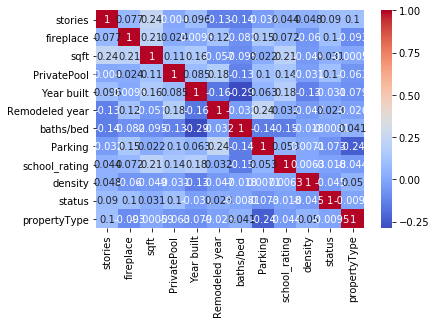

In [153]:
sns.heatmap(Features.corr(), annot=True, cmap='coolwarm')
#most of the variables have low correlation

Text(0.5, 0, 'Relative Importance')

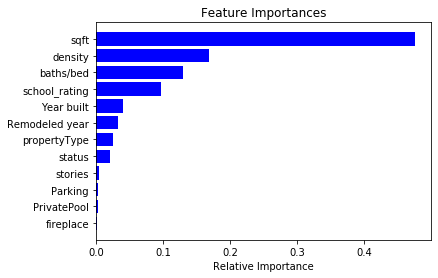

In [154]:
RFR = RandomForestRegressor(max_depth = 10)
features=Features.columns[[0,1,2,3,4,5,6,7,8,9,10,11]]
RFR.fit(Features, target)
importances = RFR.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [155]:
Features = data[['sqft', 'Year built', 'baths/bed', 'school_rating', 'density']]

# Model

In [156]:
scaler = StandardScaler()
FeaturesSt = scaler.fit_transform(Features)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(FeaturesSt, target, random_state=42, test_size=0.2)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (169949, 5)
X_test: (42488, 5)
y_train: (169949,)
y_test: (42488,)


In [158]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the regressor.
    
    :arg regr: scikit-learn regressor
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype = np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_r = clone(regr)
        folded_r.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_r.predict(X_fold_predict)
    
    meta_r = clone(regr)
    meta_r.fit(X_train, y_train)
    
    X_meta_test = meta_r.predict(X_test)
    
    return X_meta_train, X_meta_test

In [159]:
def generate_metafeatures(regrs, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of regressors.
    
    :arg regrs: list of scikit-learn regressors
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(regr, X_train, X_test, y_train, cv)
        for regr in tqdm(regrs)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [160]:
LR =  LinearRegression()
DTR = DecisionTreeRegressor(max_depth=10, criterion='mae', random_state=42)
RFR = RandomForestRegressor(max_depth=20, random_state=42)
ABR = AdaBoostRegressor(LR, n_estimators=500, learning_rate=0.8)

In [161]:
#Parameters for LR
distributions={
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'n_jobs': [-1, 5, None]
}
LRP = RandomizedSearchCV(LR, distributions, random_state=0)
search = LRP.fit(X_train, y_train)
search.best_params_

{'normalize': True, 'n_jobs': None, 'fit_intercept': True}

In [162]:
LRnew =  LinearRegression(normalize=True, fit_intercept=True)

In [163]:
#Parameters for DecisionTreeRegressor(DTR)
distributions={
    'max_depth': [3, 7, 9, 17, 30, None],
    'criterion': ['mse', 'friedman_mse'],
    'random_state': [0, 42],
    'min_samples_split': [2, 4, 7],
    'min_samples_leaf': [1, 5],
    'max_features': ['auto', 'sqrt', None]
}
r = RandomizedSearchCV(DTR, distributions, random_state=0)
search = r.fit(X_train, y_train)
search.best_params_

{'random_state': 42,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 30,
 'criterion': 'mse'}

In [164]:
DTRnew = DecisionTreeRegressor(max_depth=30, criterion='mse', random_state=0, min_samples_split=7,
                              min_samples_leaf=5, max_features='auto')

In [165]:
#Parameters for RandomForestRegressor(RFR)
distributions={
    'n_estimators': [30, 50, 100, 120],
    'criterion': ['mse', 'friedman_mse'],
    'max_depth': [5, 10, 15, None],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'n_jobs': [-1, 10],
    'random_state': [0, 10, 42]
}
r = RandomizedSearchCV(RFR, distributions, random_state=0)
search = r.fit(X_train, y_train)
DTRnewpar = search.best_params_

In [166]:
RFRnew = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1, n_estimators=100,
                           max_depth=15, criterion='mse', bootstrap=True)

In [167]:
#Parameters for AdaBoostRegressor(ABR)
distributions={
    'base_estimator': [LinearRegression(), None],
    'n_estimators': [10, 50],
    'learning_rate': [0.8, 0.75],
    'loss': ['linear', 'square', 'exponential'],
    'random_state': [0, 42]
}
r = RandomizedSearchCV(ABR, distributions, random_state=0)
search = r.fit(X_train, y_train)
search.best_params_

{'random_state': 0,
 'n_estimators': 10,
 'loss': 'exponential',
 'learning_rate': 0.8,
 'base_estimator': None}

In [168]:
ABRnew = AdaBoostRegressor(base_estimator=None, n_estimators=10, learning_rate=0.8, loss='exponential', random_state=0)

In [169]:
cv = KFold(n_splits=10, shuffle=True)
stacked_features_train, stacked_features_test = generate_metafeatures([LRnew, DTRnew, RFRnew, ABRnew],X_train, 
                                                                      X_test, y_train.values, cv)

100%|████████████████████████████████████████████| 4/4 [01:54<00:00, 25.51s/it]


In [170]:
total_features_train = np.hstack([X_train, stacked_features_train])
total_features_test = np.hstack([X_test, stacked_features_test])

In [171]:
GBR = GradientBoostingRegressor()
predictor = GBR
predictor.fit(stacked_features_train, y_train)
y_pred = predictor.predict(stacked_features_test)

In [172]:
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
print(f'R^2 GB: {round(predictor.score(stacked_features_test,y_test),4)}, MAE GB: {round(mae,2)}, RSME: {round(np.sqrt(mse),2)}')

R^2 GB: 0.7068, MAE GB: 0.35, RSME: 0.53


![title](fin.jpg)

During my work the score has inceased from 0.1 at the beginning to what I have now. This is not the best score and probably additional work is required for data and ML. 
- add more features like the distance from center based on street and additional data of central street in each city, heating, cooling 
- optimize the model: find the best parameters to reduce time, find the best steking set
- increase the NA treatments
- increase exceptions treatment
- code refactoring and style improvement
- Prepare the models to Production
- Improve code style according to pep8

Is scheduled for the next sprint :)